## DOWNLOAD AND IMPORT LIBRARIES

In [2]:


!pip3 install pandas matplotlib numpy scikit-surprise numpy

print('\n\n\n>> Libraries Installed')




>> Libraries Installed


In [3]:
import pandas as pd
import numpy as np

from surprise import Reader, Dataset, SVD

from surprise.accuracy import rmse, mae
from surprise.model_selection import cross_validate

print('>> Libraries imported.')

>> Libraries imported.


## DATA CLEANING

DATASET FROM: https://www.kaggle.com/zygmunt/goodbooks-10k

In [4]:
booksdf= pd.read_csv('books.csv')

booksdf.drop(['id', 'best_book_id', 'work_id', 'books_count', 'isbn',
       'isbn13', 'authors', 'original_publication_year', 
       'title', 'language_code', 'average_rating', 'ratings_count',
       'work_ratings_count', 'work_text_reviews_count', 'ratings_1',
       'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url',
       'small_image_url'], axis=1, inplace=True)
booksdf = booksdf.sort_values(["book_id"])
booksdf.head()

,book_id,original_title
26,1,Harry Potter and the Half-Blood Prince
20,2,Harry Potter and the Order of the Phoenix
1,3,Harry Potter and the Philosopher's Stone
17,5,Harry Potter and the Prisoner of Azkaban
23,6,Harry Potter and the Goblet of Fire


In [5]:
df1 = pd.read_csv ("ratings.csv")
columns_titles = ['user_id', 'book_id', 'rating']
df1=df1.reindex(columns=columns_titles)
df1.head()
df = pd.merge(df1,booksdf)
df.drop('original_title', axis=1, inplace= True)
print(df.shape)
df = df.sort_values('user_id', ascending = True)


(79701, 3)


## INFORMATION ABOUT RAW DATA

In [6]:
df.isna().sum()

user_id    0
book_id    0
rating     0
dtype: int64

In [7]:
n_movies = df["book_id"].nunique() 
n_users = df["user_id"].nunique() 

print(n_movies)
print(n_users)

812
28906


In [8]:
av = df['rating'].count()
tot = n_movies * n_users
miss = tot - av
sp = (miss/tot)*100
print(f'Sparsity in Rating: {sp}')

Sparsity in Rating: 99.66043748395938


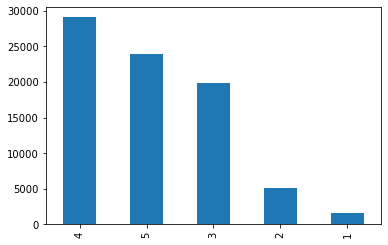

In [9]:
df['rating'].value_counts().plot(kind='bar')

## FILTERING RARE DATA

In [10]:
min_ratings = 3
filter_movies = df['book_id'].value_counts() > min_ratings
filter_movies = filter_movies[filter_movies].index.tolist()

min_user_ratings = 3
filter_users = df['user_id'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

print(df.shape)
df = df[(df['book_id'].isin(filter_movies)) & (df['user_id'].isin(filter_users))]
print(df.shape)

(79701, 3)
(44830, 3)


## BUILDING TESTSET AND ANTISET

In [11]:
cols = ['user_id', 'book_id', 'rating']
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df[cols], reader)
t_s = data.build_full_trainset()
a_s = t_s.build_anti_testset()

## TRAINING THE MODEL

In [12]:
algo = SVD(n_epochs = 25 ,biased=True, verbose=True,lr_pu=0.001, lr_qi=0.001, lr_bu=0.001, lr_bi=0.001)
cross_validate(algo, data, measures=['RMSE'], cv=5, verbose = True, return_train_measures=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
P

{'test_rmse': array([0.92867613, 0.93439218, 0.92587314, 0.91470902, 0.93506852]),
 'train_rmse': array([0.85064088, 0.84948969, 0.85103064, 0.85301811, 0.84915671]),
 'fit_time': (2.636476755142212,
  2.618694543838501,
  2.600537061691284,
  2.609074115753174,
  2.9200947284698486),
 'test_time': (0.07593107223510742,
  0.08388972282409668,
  0.06790781021118164,
  0.06790924072265625,
  0.06394720077514648)}

In [13]:
predictions = algo.test(a_s)

## COMPLETE ANTISET OF PREDICTIONS:

In [14]:
def round_of_rating(number):
        return round(2*number)/2
df = pd.DataFrame(predictions)
df.drop('r_ui', axis=1, inplace=True)
df.drop('details', axis=1, inplace=True)
df['est']= df['est'].apply(round_of_rating )
df.rename(columns = {'uid': 'user_id', 'iid':'book_id', 'est': 'rating(predicted)'}, inplace = True)
df = df.sort_values('user_id', ascending = True)
df.head()

,user_id,book_id,rating(predicted)
0,7,9516,4.0
531,7,4076,4.0
532,7,4006,4.0
533,7,8695,4.0
534,7,9799,4.0


In [20]:
to_complete = pd.read_csv('to_read.csv')
to_complete['ratings']=df['rating(predicted)']
to_complete.to_csv('To_read_predictions.csv')
to_complete.head()

# IMPROVEMENT: Recommending top n=3 books based on predictions, of all users

In [16]:
from collections import defaultdict
def get_top_n(predictions, n):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

   
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n
top_n = get_top_n(predictions, n=3)

In [17]:
table = [(uid, *[iid for (iid, rating) in user_ratings]) for uid, user_ratings in top_n.items() ]
reccs = pd.DataFrame(table)
reccs.columns = [ 'UserId', 'Rec1', 'Rec2', 'Rec3']
reccs = reccs.sort_values(["UserId"], ascending = True)
reccs.head()


,UserId,Rec1,Rec2,Rec3
0,7,6462,1274,1618
1,23,1618,2767,2956
2,35,2767,4373,7996
3,49,998,2095,8909
4,75,4708,976,6462


## MATCH OUTPUT WITH BOOK NAMES

In [18]:
df1 = pd.merge(reccs, booksdf , left_on= 'Rec1', right_on= 'book_id')
df1.drop('Rec1', axis=1, inplace= True)
df1.drop('book_id', axis=1, inplace= True)
df1.rename(columns = {'original_title':'Recommended Book 1'}, inplace = True)
##################################################################
df2 = pd.merge(df1, booksdf , left_on= 'Rec2', right_on= 'book_id')
df2.drop('Rec2', axis=1, inplace= True)
df2.drop('book_id', axis=1, inplace= True)
df2.rename(columns = {'original_title':'Recommended Book 2'}, inplace = True)
##################################################################
finalrec = pd.merge(df2, booksdf , left_on= 'Rec3', right_on= 'book_id')
finalrec.drop('Rec3', axis=1, inplace= True)
finalrec.drop('book_id', axis=1, inplace= True)
finalrec.rename(columns = {'original_title':'Recommended Book 3'}, inplace = True)
print(finalrec.shape)
finalrec = finalrec.sort_values(['UserId'], ascending = True)
finalrec.to_csv('RECOMMENDATIONS_OUTPUT.csv', index= False)
finalrec.head()

(6725, 4)


,UserId,Recommnded Book 1,Recommnded Book 2,Recommnded Book 3
0,7,His Excellency: George Washington,"Men Are from Mars, Women Are from Venus Book o...",The Curious Incident of the Dog in the Night-Time
3041,23,The Curious Incident of the Dog in the Night-Time,A People's History of the United States: 1492 ...,The Adventures of Huckleberry Finn
6158,35,A People's History of the United States: 1492 ...,First They Killed My Father: A Daughter of Cam...,Redwall
1547,49,The Millionaire Next Door: The Surprising Secr...,The Universe in a Nutshell,The War of the Worlds
4101,75,The Beautiful and Damned,Deception Point,His Excellency: George Washington
